### Simulación de Operaciones de Pulling



In [7]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

import simpy
import random, math

import warnings
warnings.filterwarnings("ignore")

In [8]:
semilla=30
num_equipos=1
tiempo_min=28 # mínimo de intervención
tiempo_max=32 # máximo de intervención
t_arribos=20 # promedio de arribos de pozos
tot_pozos=1200
te=0 # tiempo de espera total
dt=0 # duracion del servicio
fin=0 # hora en la que finaliza la intervención del pozo

In [9]:
def intervencion(pozo): 
    global dt
    R=random.random()
    tiempo=tiempo_max-tiempo_min
    tiempo_int=tiempo_min+(tiempo*R)
    yield env.timeout(tiempo_int) # deja correr el tiempo en tiempo_int
    print('WORK    end: %s finaliza   intervención en %.2f' % (pozo,tiempo_int))
    dt=dt+tiempo_int

In [10]:
def pozo(env,name,equipos):
    global te
    global fin
    global ultimo_pozo_arribo,ultimo_pozo_reparado
    llega=env.now 
    print('---> ARRIBO: %s llegó a la intervención en %.2f' % (name,llega))
    ultimo_pozo_arribo=name
    with equipos.request() as request: # Espera su turno
        yield request # Obtiene turno
        pasa=env.now # Guarda el minuto cuado comienza a ser atendido
        espera=pasa-llega
        te=te+espera
        print('WORK  start: %s comienza en %.2f esperando %.2f'% (name,pasa,espera))
        yield env.process(intervencion(name)) # Invoca al proceso intervención
        deja=env.now #Guarda el minuto en que termina el proceso intervención
        print('<--- SALIDA: %s termina con el PU en el minuto %.2f' % (name,deja))
        ultimo_pozo_reparado=name
        fin=deja # Conserva globalmente el ultimo minuto de la simulacion


In [11]:
def principal (env,equipos):
    llegada=0
    i=0
    for i in range (tot_pozos):
        R=random.random()
        llegada=-t_arribos*math.log(R)
        yield env.timeout(llegada) # Deja transcurrir un tiempo entre uno y otro
        i+=1
        env.process(pozo(env,'Pozo %d' % i,equipos))


---> ARRIBO: Pozo 1 llegó a la intervención en 12.36
WORK  start: Pozo 1 comienza en 12.36 esperando 0.00
WORK    end: Pozo 1 finaliza   intervención en 20.60
<--- SALIDA: Pozo 1 termina con el PU en el minuto 32.96
---> ARRIBO: Pozo 2 llegó a la intervención en 37.17
WORK  start: Pozo 2 comienza en 37.17 esperando 0.00
---> ARRIBO: Pozo 3 llegó a la intervención en 45.67
WORK  start: Pozo 3 comienza en 45.67 esperando 0.00
WORK    end: Pozo 2 finaliza   intervención en 24.20
<--- SALIDA: Pozo 2 termina con el PU en el minuto 61.37
---> ARRIBO: Pozo 4 llegó a la intervención en 72.83
WORK  start: Pozo 4 comienza en 72.83 esperando 0.00
WORK    end: Pozo 3 finaliza   intervención en 27.94
<--- SALIDA: Pozo 3 termina con el PU en el minuto 73.62
---> ARRIBO: Pozo 5 llegó a la intervención en 81.70
WORK  start: Pozo 5 comienza en 81.70 esperando 0.00
---> ARRIBO: Pozo 6 llegó a la intervención en 97.17
---> ARRIBO: Pozo 7 llegó a la intervención en 97.32
WORK    end: Pozo 4 finaliza   int

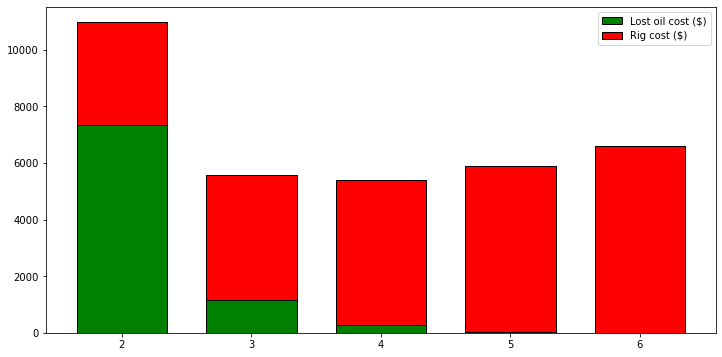

In [19]:
cte_oil=1*6.29*70 #1m3opd x $70/bbl
cte_rig_op=3000/24 # tarifa operativa $3,000/day
cte_rig_st=1000/24 # tarifa stand by $1,000/day

data_simu=[]
data_cost=[]

tabla_simu=pd.DataFrame(data_simu,columns=['Rigs','Tiempo de espera (hs)','Tiempo de trabajo total (hs)','Eficiencia del sistema (%)',
'Ultimo Pozo arribado','Ultimo Pozo reparado'])
tabla_cost=pd.DataFrame(data_cost,columns=['Rigs','Lost oil cost ($)','Rig cost ($)','Total cost ($)'])

for j in range(2,7): #2-7
    
    semilla=30
    num_equipos=j 
    tiempo_min, tiempo_max =20, 40 # 28, 32
    t_arribos, tot_pozos=20, 1200 #20
    te, dt, fin=0, 0, 0

    random.seed(semilla)
    env=simpy.Environment() # Crea el objeto entorno de simulacion
    equipos=simpy.Resource(env,num_equipos) # Crea los recursos (equipos)
    env.process(principal(env,equipos)) #Invoca el proceso princial
    env.run(until=17520) # 2 años=17,520 horas - 1 año=8,760 horas - 6 meses=4,380 horas - 1 mes=730 horas
    
    #print('Tiempo de espera acumulado en línea (lost oil): %.2f' % te)
    #print('Tiempo de intervención total (costo servicio): %.2f' % dt)
    #print('Ultimo pozo arribo %s y último pozo reparado %s' % (ultimo_pozo_arribo,ultimo_pozo_reparado))
    lpc=te/fin
    #print('Longitud promedio de la cola: %.2f' % lpc)
    tep=te/tot_pozos
    #print('Tiempo de espera promedio: %.2f' % tep)
    upi=(dt/fin)/num_equipos
    #print('Uso promedio de la instalacion: %.1f' % upi)

    new_data_simu = {'Rigs':num_equipos,'Tiempo de espera (hs)':te,'Tiempo de trabajo total (hs)':dt,'Eficiencia del sistema (%)':upi*100,
    'Ultimo Pozo arribado':ultimo_pozo_arribo,'Ultimo Pozo reparado':ultimo_pozo_reparado}
    tabla_simu=tabla_simu.append(new_data_simu,ignore_index=True)

    lost_oil=(te*cte_oil)/1000
    rig_cost=(dt*cte_rig_op+fin*cte_rig_st*(1-upi)*num_equipos)/1000
    new_data_cost={'Rigs':num_equipos,'Lost oil cost ($)':lost_oil,'Rig cost ($)':rig_cost,'Total cost ($)':lost_oil+rig_cost}
    tabla_cost=tabla_cost.append(new_data_cost,ignore_index=True)

#tabla_simu['Tiempo de espera'] = tabla_simu['Tiempo de espera'].astype(float)
#tabla_simu['Tiempo de trabajo total'] = tabla_simu['Tiempo de trabajo total'].astype(float)
#tabla_simu['Eficiencia del sistema'] = tabla_simu['Eficiencia del sistema'].astype(float)

#tabla_cost['Lost oil cost']=tabla_cost['Lost oil cost'].astype(float)
#tabla_cost['Rig cost']=tabla_cost['Rig cost'].astype(float)
#tabla_cost['Total cost']=tabla_cost['Total cost'].astype(float)

pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.1f}'.format

fig,ax=plt.subplots(figsize=(12,6))
BarrasI=ax.bar(tabla_cost['Rigs'],tabla_cost['Lost oil cost ($)'],width=0.7,color='green',label='Lost oil cost ($)',ec='k')
BarrasG=ax.bar(tabla_cost['Rigs'],tabla_cost['Rig cost ($)'],bottom=tabla_cost['Lost oil cost ($)'],width=0.7,color='red',label='Rig cost ($)',ec='k')
plt.legend()

In [20]:
print(tabla_cost.to_string(index=False))
#tabla_cost

Rigs Lost oil cost ($) Rig cost ($) Total cost ($)
 2.0           7,345.2      3,622.1       10,967.3
 3.0           1,169.6      4,386.6        5,556.2
 4.0             276.4      5,127.6        5,404.0
 5.0              41.6      5,854.3        5,895.9
 6.0               1.2      6,579.1        6,580.3


In [21]:
print(tabla_simu.to_string(index=False)) 
#tabla_simu

Rigs Tiempo de espera (hs) Tiempo de trabajo total (hs) Eficiencia del sistema (%) Ultimo Pozo arribado Ultimo Pozo reparado
   2              16,682.3                     25,954.8                       74.1             Pozo 878             Pozo 870
   3               2,656.3                     26,373.4                       50.2             Pozo 886             Pozo 883
   4                 627.8                     26,505.1                       37.8             Pozo 893             Pozo 891
   5                  94.4                     26,513.8                       30.3             Pozo 889             Pozo 889
   6                   2.8                     26,508.5                       25.3             Pozo 889             Pozo 889
